In [347]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [348]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices

df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index, the actual EV data is handled separatel
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_202101010000_202112312359_Stunde (2).xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11987
1,0.11719
2,0.11368
3,0.11192
4,0.10939


In [349]:

def settings_to_target_df(pricing_type, operation_type, feed_in_type,grid_charge_type, grid_charging_allowed,hp=False,ev=False,costs=False):
    target_df = pd.read_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    if hp:
        target_df = pd.read_pickle(f"./output/detailed_consumption/HP_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    elif ev:
        target_df = pd.read_pickle(f"./output/detailed_consumption/EV_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    
    elif costs:
        target_df = pd.read_pickle(f"./output/detailed_financials/Costs_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")

    return target_df



In [350]:
def calculate_peaks_based_on_case(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    target_df = target_df[["Sum"]]
    heat_pump_peak_day = '2019-12-01'
    pv_peak_day = '2019-05-13'
    pv_peak = target_df["Sum"][pv_peak_day].abs().max()
    heat_pump_peak_day = '2019-12-01'
    hp_peak = target_df["Sum"][heat_pump_peak_day].abs().max()
    ev_peak_day = "2019-01-05"
    ev_peak = target_df["Sum"][ev_peak_day].abs().max()
    total_peak = target_df["Sum"].abs().max()
    
    case["worst_hp_day_peak_load"] = hp_peak
    case["worst_pv_day_peak_load"] = pv_peak
    case["worst_ev_day_peak_load"] = ev_peak
    case["worst_total_peak_load"] = total_peak
    
def calculate_agg_hp_consumption(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    total_hp_consumption = target_df["Sum"].sum()
    case["yearly_hp_consumption"] = total_hp_consumption
    
def calculate_agg_ev_consumption(target_df, case):
    target_df["Sum"] = target_df.sum(axis=1)
    total_ev_consumption = target_df["Sum"].sum()
    case["yearly_ev_consumption"] = total_ev_consumption

In [420]:


case_volumetric_fit_gcfalse_constant = {"name":"Constant Volumetric_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_fit_gctrue_constant = {"name":"Constant Volumetric_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"True"}

case_peak_fit_gcfalse_constant = {"name":"Constant Peak_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_fit_gctrue_constant = {"name":"Constant Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "constant", "operation_type" : "dynamic","grid_charging_allowed":"True"}


case_volumetric_fit_gcfalse = {"name":"Dynamic Volumetric_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_fit_gctrue = {"name":"Dynamic Volumetric_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}

case_volumetric_dynamic_gcfalse = {"name":"Dynamic Volumetric_DynFeed_GC False","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_volumetric_dynamic_gctrue = {"name":"Dynamic Volumetric_DynFeed_GC True","feed_in_tariff" :"dynamic", "grid_charge_type" : "volumetric", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}

case_peak_fit_gcfalse = {"name":"Dynamic Peak_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_fit_gctrue = {"name":"Dynamic Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}

case_peak_fit_gcfalse = {"name":"Dynamic Peak_FIT_GC False","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_fit_gctrue = {"name":"Dynamic Peak_FIT_GC True","feed_in_tariff" :"fit", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}

case_peak_dynamic_gcfalse = {"name":"Dynamic Peak_DynFeed_GC_GC False","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"False"}
case_peak_dynamic_gctrue = {"name":"Dynamic Peak_DynFeed_GC_GC True","feed_in_tariff" :"dynamic", "grid_charge_type" : "peak", "pricing_type" : "dynamic", "operation_type" : "dynamic","grid_charging_allowed":"True"}


#case_volumetric_constant = {"name":"Constant Volumetric_FIT","feed_in_tariff" :0.07, "grid_charges" : "volumetric", "handling_fee" : 0.02, "pricing_type" : "constant", "operation_type" : "dynamic"}
#case_peak = {"name":"Dynamic Peak_FIT","feed_in_tariff" :0.07, "grid_charges" : "peak", "handling_fee" : 0.02, "pricing_type" : "dynamic", "operation_type" : "dynamic"}
#case_peak_constant = {"name":"Constant Peak_FIT","feed_in_tariff" :0.07, "grid_charges" : "peak", "handling_fee" : 0.02, "pricing_type" : "constant", "operation_type" : "dynamic"}
#case_volumetric_constant = {"name":"Constant Volumetric_FIT","feed_in_tariff" :0.07, "grid_charges" : "volumetric", "handling_fee" : 0.02, "pricing_type" : "constant", "operation_type" : "dynamic"}


#cases = [case_volumetric_constant, case_volumetric, case_peak_constant, case_peak]
cases = [case_volumetric_fit_gcfalse_constant, case_volumetric_fit_gctrue_constant, case_volumetric_fit_gcfalse, case_volumetric_fit_gctrue, case_peak_fit_gcfalse, case_peak_fit_gctrue]
cases = [case_volumetric_fit_gcfalse_constant, case_volumetric_fit_gcfalse, case_peak_fit_gcfalse_constant, case_peak_fit_gcfalse]

for case in cases: 
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    
    calculate_peaks_based_on_case(target_df_consumption, case)
    target_df_hp = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"],hp=True)
    
    calculate_agg_hp_consumption(target_df_hp,case)
    
    target_df_ev = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"],ev=True)
    
    calculate_agg_ev_consumption(target_df_ev,case)


In [421]:
cases_comparison = pd.DataFrame(cases).set_index("name")
cases_comparison

,feed_in_tariff,grid_charge_type,pricing_type,operation_type,grid_charging_allowed,worst_hp_day_peak_load,worst_pv_day_peak_load,worst_ev_day_peak_load,worst_total_peak_load,yearly_hp_consumption,yearly_ev_consumption
name,,,,,,,,,,,
Constant Volumetric_FIT_GC False,fit,volumetric,constant,dynamic,False,1212.502531,1922.318813,855.483898,2264.257774,2.388752e+06,968179.931808
Dynamic Volumetric_FIT_GC False,fit,volumetric,dynamic,dynamic,False,2194.363374,1912.704658,1503.870812,2784.534588,2.388752e+06,968179.931808
Constant Peak_FIT_GC False,fit,peak,constant,dynamic,False,1010.466022,1884.676080,714.100279,2256.214988,2.388752e+06,968179.931787
Dynamic Peak_FIT_GC False,fit,peak,dynamic,dynamic,False,1714.188454,1943.470262,1322.253714,2283.305984,2.388752e+06,968179.931785


In [422]:
cases_comparison[["worst_hp_day_peak_load","worst_pv_day_peak_load","worst_ev_day_peak_load","worst_total_peak_load"]].style.background_gradient(cmap='RdYlGn_r')

,worst_hp_day_peak_load,worst_pv_day_peak_load,worst_ev_day_peak_load,worst_total_peak_load
name,,,,
Constant Volumetric_FIT_GC False,1212.502531,1922.318813,855.483898,2264.257774
Dynamic Volumetric_FIT_GC False,2194.363374,1912.704658,1503.870812,2784.534588
Constant Peak_FIT_GC False,1010.466022,1884.676080,714.100279,2256.214988
Dynamic Peak_FIT_GC False,1714.188454,1943.470262,1322.253714,2283.305984


In [423]:
cases_comparison[["yearly_hp_consumption"]].style.background_gradient(cmap='RdYlGn_r')



,yearly_hp_consumption
name,
Constant Volumetric_FIT_GC False,2388752.128993
Dynamic Volumetric_FIT_GC False,2388752.128993
Constant Peak_FIT_GC False,2388752.128990
Dynamic Peak_FIT_GC False,2388752.128993


In [424]:
cases_comparison[["yearly_ev_consumption"]].style.background_gradient(cmap='RdYlGn_r')



,yearly_ev_consumption
name,
Constant Volumetric_FIT_GC False,968179.931808
Dynamic Volumetric_FIT_GC False,968179.931808
Constant Peak_FIT_GC False,968179.931787
Dynamic Peak_FIT_GC False,968179.931785


# Comparing load patterns

In the following, we compare resulting aggregated load patterns by policies.

In [425]:
compare_df = pd.DataFrame()


for case in cases:
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    compare_df[case["name"]] = target_df_consumption.sum(axis=1)
    compare_df.index = target_df_consumption.index
    
compare_df["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].values
compare_df.index = compare_df.index.strftime('%Y-%m-%d %H:%M:%S')


<ipython-input-427-bf7692da0923>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


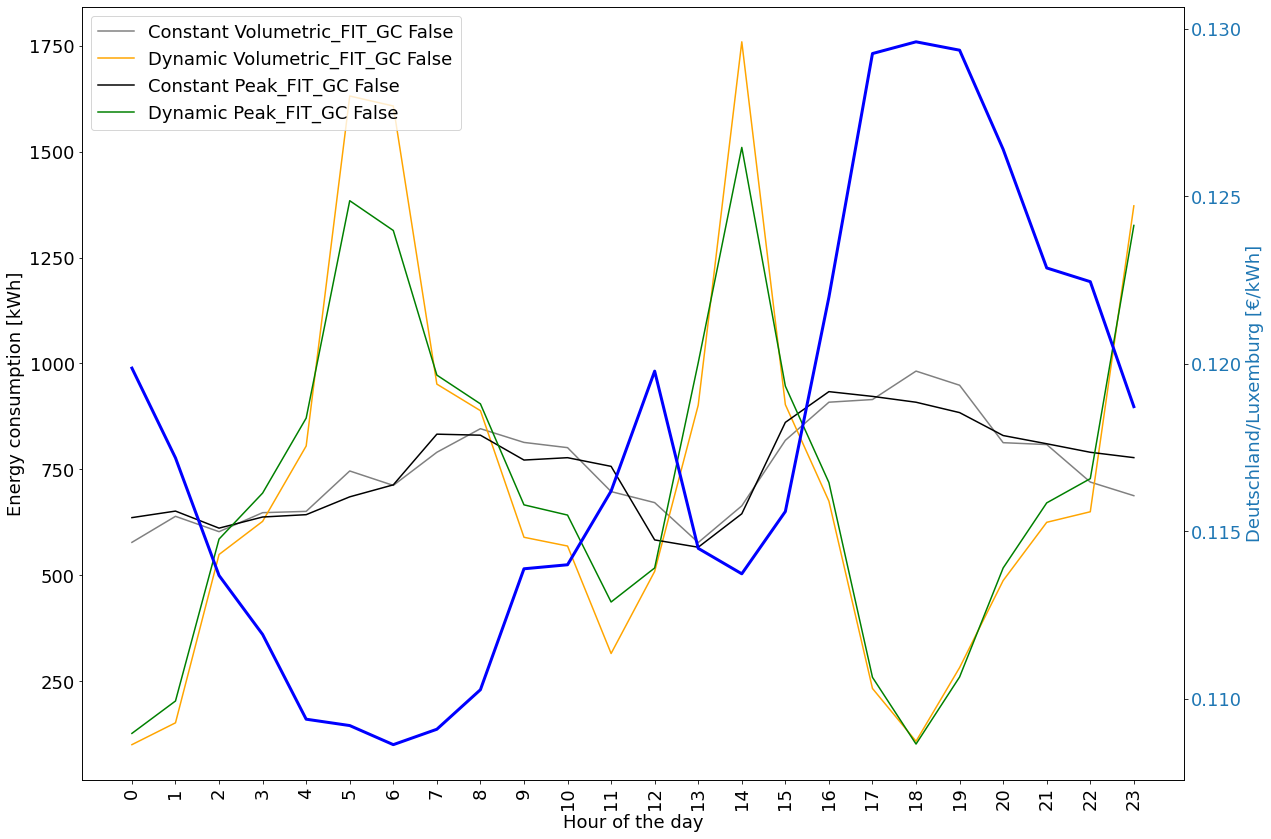

In [427]:
day = 0

fig, ax1 = plt.subplots()

plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (18,12)


color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy consumption [kWh]', color="black")
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Constant Volumetric_FIT_GC False'].iloc[day*24:(day+1)*24], color="grey", label='Constant Volumetric_FIT_GC False')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Dynamic Volumetric_FIT_GC False'].iloc[day*24:(day+1)*24], color="orange", label='Dynamic Volumetric_FIT_GC False')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Constant Peak_FIT_GC False'].iloc[day*24:(day+1)*24], color="black", label='Constant Peak_FIT_GC False')
ax1.plot(compare_df.index[day*24:(day+1)*24], compare_df['Dynamic Peak_FIT_GC False'].iloc[day*24:(day+1)*24], color="green", label='Dynamic Peak_FIT_GC False')
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(compare_df.index[day*24:(day+1)*24], compare_df['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24],lw=3,color="blue")
ax2.tick_params(axis='y', labelcolor=color3)
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


fig.tight_layout()  # for a neat layout
plt.show()



In [414]:
### Comparing costs

costs = []

for case in cases:
    target_df_consumption = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"])
    target_df_costs = settings_to_target_df(case["pricing_type"], case["operation_type"], case["feed_in_tariff"],case["grid_charge_type"],
                                                     case["grid_charging_allowed"],costs=True)
    
    # creating two data
    df_consumption = target_df_consumption.copy()
    df_feedin = target_df_consumption.copy()
    df_consumption[df_consumption < 0] = 0
    df_feedin[df_feedin > 0] = 0
    df_feedin = df_feedin.abs()
    
    if case["grid_charge_type"] == "volumetric":
        total_costs_grid = df_consumption.sum().sum()*0.07
    elif case["grid_charge_type"] == "peak":
        total_costs_grid = df_consumption.max()*37.86
        total_costs_grid = total_costs_grid.sum()
        
    if case["pricing_type"]=="constant":
        total_costs_energy = df_consumption.sum()*(df_p.mean()[0])
        total_costs_energy = total_costs_energy.sum()
        pass
    elif case["pricing_type"]=="dynamic":
        total_costs_energy = (df_consumption.values*df_p.values).sum()
        
    if case["feed_in_tariff"] == "fit":
        total_feed_in_profits = ((df_feedin.sum()*(0.07))).sum()
    
    cost_case = {"name":case["name"],"Grid Costs":total_costs_grid,"Energy Costs":total_costs_energy,"Feed In Compensation":total_feed_in_profits,"Total Costs":total_costs_energy+total_costs_grid-total_feed_in_profits}
    costs.append(cost_case)

<AxesSubplot: xlabel='name'>

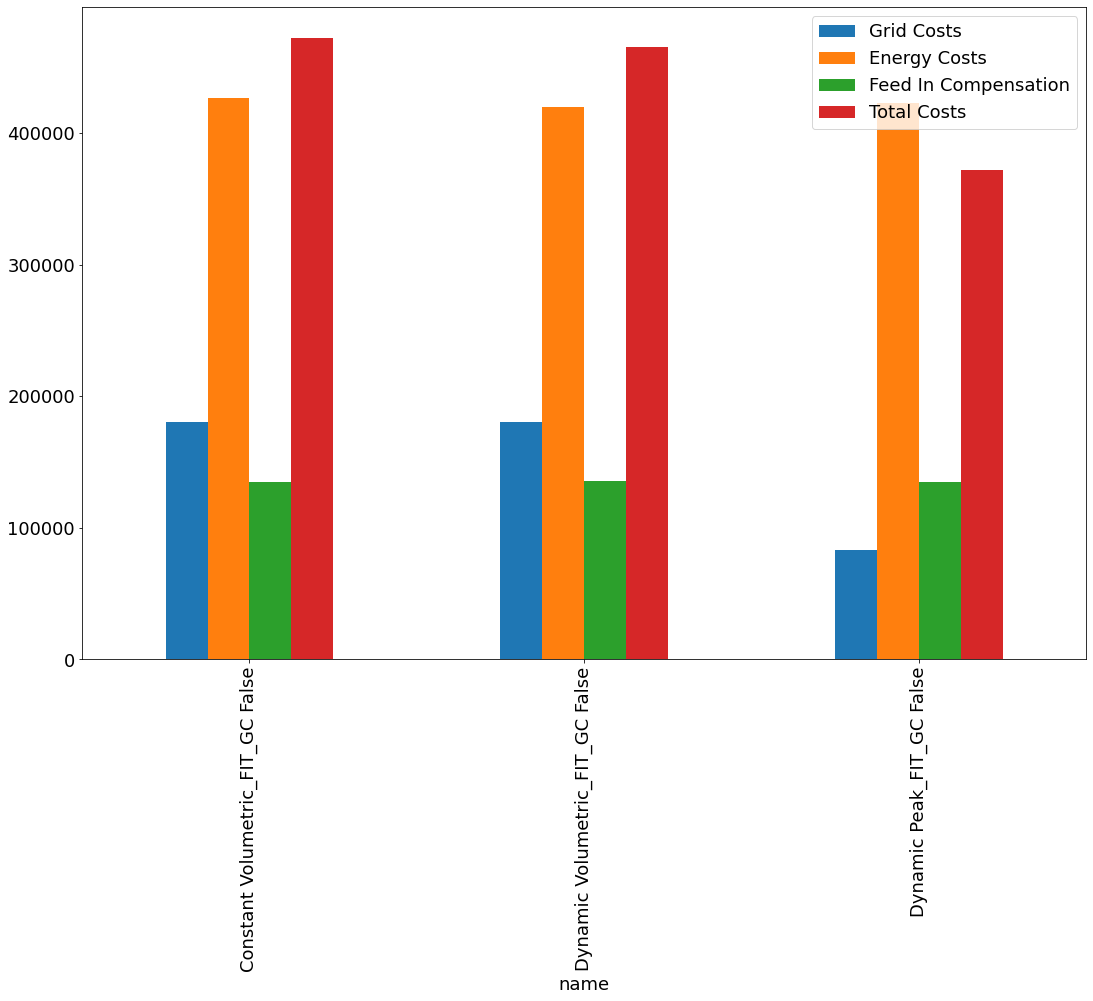

In [415]:
pd.DataFrame(costs).set_index("name").plot.bar()

In [416]:
costs

[{'name': 'Constant Volumetric_FIT_GC False',
  'Grid Costs': 180130.30142501893,
  'Energy Costs': 426779.93837298756,
  'Feed In Compensation': 134787.62313145993,
  'Total Costs': 472122.61666654656},
 {'name': 'Dynamic Volumetric_FIT_GC False',
  'Grid Costs': 180518.04496890315,
  'Energy Costs': 419891.14497408085,
  'Feed In Compensation': 135174.17055048657,
  'Total Costs': 465235.0193924975},
 {'name': 'Dynamic Peak_FIT_GC False',
  'Grid Costs': 83104.73455843473,
  'Energy Costs': 423110.16269604326,
  'Feed In Compensation': 134710.56305165705,
  'Total Costs': 371504.33420282096}]